In [3]:
# Import dependencies
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import datetime as dt
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt 

In [4]:
# Create the connection engine to the sqlite database
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [5]:
# Establish Base for which classes will be constructed 
Base = automap_base()

In [6]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [7]:
# Assign the station class to a variable called `Station`
Station = Base.classes.stations

In [8]:
# Assign the measurements class to a variable called `Measurement`
Measurement = Base.classes.measurements

In [9]:
# To query the server we use a Session object
session = Session(bind=engine)

<h1>Precipitation Analysis</h1>

In [71]:
# Calculate latest date in measurements table
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert latest date to datetime object
latest_date_dt = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate date 12 months ago as datetime object
year_ago_date_dt = latest_date_dt - dt.timedelta(days=365)

# Convert date 12 months ago to string
year_ago_date = year_ago_date_dt.strftime('%Y-%m-%d')

# Print out results
print(f"Most recent date: {latest_date}" + "\n" + f"Date 12 months ago: {year_ago_date}")

Most recent date: 2017-08-23
Date 12 months ago: 2016-08-23


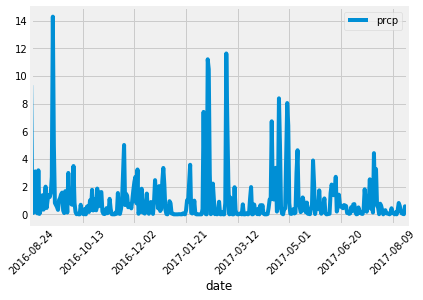

In [72]:
# Retrieve the last 12 months of precipitation data.
last_12_months_precip = session.query(Measurement.date, func.sum(Measurement.prcp))\
                    .filter(Measurement.date >= year_ago_date)\
                    .group_by(Measurement.date)\
                    .order_by(Measurement.date).all()
              
#Load the query results into a Pandas DataFrame and set the index to the date column. 
last_12_months_precip_df = pd.DataFrame(last_12_months_precip, columns=['date', 'prcp'])
last_12_months_precip_df = last_12_months_precip_df.set_index('date')

#Plot the results using the DataFrame plot method.
last_12_months_precip_df.plot()

# Rotate the xticks for the dates
plt.xticks(rotation='45')
plt.show() 

In [53]:
last_12_months_precip_df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


<h1>Station Analysis</h1>

In [60]:
# Calculate the total number of stations.
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations.\n")

# Query to create a list of stations by the number of observations
stations_by_tobs = session.query(Measurement.station, func.count(Measurement.tobs))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.tobs).desc()).all()

# Print list of stations by the number of observations
print("List of stations and number of observations:\n", stations_by_tobs,"\n")
        
# Get name of most active station
most_active_station_name = stations_by_tobs[0][0]

# Get tobs of most active station
most_active_station_tobs = stations_by_tobs[0][1]

# Print most active station and 
print(f"The most active station is {most_active_station_name} with {most_active_station_tobs} observations." + "\n")

There are 9 stations.

List of stations and number of observations:
 [('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)] 

The most active station is USC00519281 with 2772 observations.



In [61]:
# Retrieve the last 12 months of temperature observation data (tobs).
# Filtered by the station with the highest number of observations.
tobs_by_max_station = session.query(Measurement.tobs)\
                    .filter(Measurement.date >= year_ago_date)\
                    .filter(Measurement.station == most_active_station_name).all()

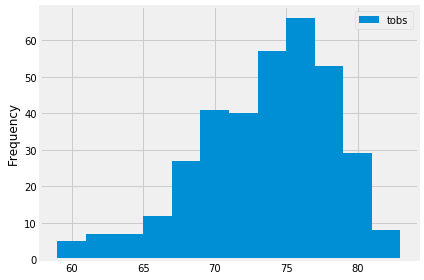

In [62]:
# Plot the last twelve months of temperature observations by the station with the highest number of obersvations
# Binning into groups of 12
tobs_by_max_station_df = pd.DataFrame(tobs_by_max_station, columns=['tobs'])
tobs_by_max_station_df.plot.hist(bins=12)
plt.tight_layout()
plt.show() 

<h1>Temperature Analysis</h1>

In [47]:
def calc_temps(start_date, end_date):
# Dates must be in YYYY-MM-DD format
# Returns the minimum, average, and maximum temperatures for the given date range

    # Query database for temperatures between start and end date
    tobs = session.query(Measurement.tobs)\
            .filter(Measurement.date >= start_date)\
            .filter(Measurement.date <= end_date).all()
    
    # Conver results to dataframe
    tobs_df = pd.DataFrame(tobs, columns=['tobs'])
    
    # Return minimum, average and maximum temperatures
    return (tobs_df['tobs'].min(), round(tobs_df['tobs'].mean(),1), tobs_df['tobs'].max())
    
# Call calc_temps function
tmin, tavg, tmax = calc_temps("2016-01-01", "2017-08-31")

# Print results
print(f"Min: {tmin} \nAvg: {tavg} \nMax: {tmax}")

Min: 56 
Avg: 74.1 
Max: 87


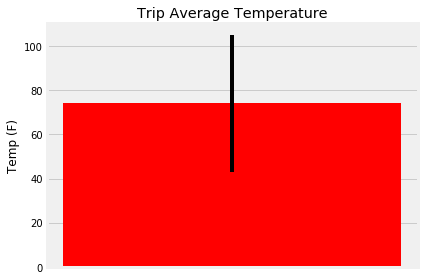

In [48]:
# Plot chart
fig, ax = plt.subplots()
ax.bar(0, tavg, color='r', yerr=tmax-tmin)
ax.get_xaxis().set_visible(False)
plt.ylabel('Temp (F)')
plt.title('Trip Average Temperature')
plt.tight_layout()
plt.show()